In [1]:
import os
import spacy
import warnings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import spacy
nlp = spacy.load('en_core_web_sm')


from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

import contractions
import nltk
import string

#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
patient_notes = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features = pd.read_csv("features.csv")
#one case has many feature_num
train = pd.read_csv("train.csv")

train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')

pd.set_option('display.max_colwidth', None)
display(train.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms"


### Pre-processing steps to clean the text - pn_history

In [6]:
train["pn_history_lower"] = train["pn_history"].str.lower()
regex = re.compile(r'<[^>]+>')
train["pn_history_noContractions"] = train["pn_history_lower"].apply(contractions.fix)

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train["pn_history_noUnicode"] = train["pn_history_noContractions"].apply(remove_unicode_chars)

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
train["pn_history_noPuncts"] = train["pn_history_noUnicode"].apply(remove_punctuations)

#def remove_stopwords(text):
#    return " ".join([word for word in str(text).split() if word not in stop_words])
#train["tweet_noStopwords"] = train["tweet_noPuncts"].apply(remove_stopwords)
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train["pn_history_noES"] = train["pn_history_noPuncts"].apply(remove_extra_spaces)
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train["pn_history_preprocessed"] = train["pn_history_noES"].apply(lemmatize_text)

In [8]:
train = train.drop_duplicates(["pn_history_preprocessed"])

## Model 2 : KeyBert with Bio_Clinical BERT

In [10]:
from keybert import KeyBERT
from tqdm import tqdm

In [11]:
model = KeyBERT(model="emilyalsentzer/Bio_ClinicalBERT")

No sentence-transformers model found with name /Users/aishwariyagupta/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (ini

## Applying KEYBERT Model

## Extracting 2 keywords

In [14]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 2),
                use_mmr=True, 
                diversity=0.7))

1000it [18:49,  1.13s/it]


In [15]:
train = train.reset_index(drop=True)

In [16]:
train = train.join(pd.DataFrame(l, columns=['first_keyword', 'second_keyword', 'third_keyword']))

In [19]:
train.to_csv("two_keywords_extraction_bioclinicalBERT.csv")

In [20]:
#seprating keyword along with cosine similarity
def func(x):
    return x[1]
train['first_keyword_score'] = train.first_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['first_keyword'] = train.first_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['second_keyword_score'] = train.second_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['second_keyword'] = train.second_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['third_keyword_score'] = train.third_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['third_keyword'] = train.third_keyword.apply(lambda x: func(x))

In [21]:
train.to_csv("two_keywords_extraction_with_score_bioclinicalBERT.csv")

## Extracting 3 keywords

In [22]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 3),
                use_mmr=True, 
                diversity=0.7))

1000it [28:23,  1.70s/it]


In [23]:
train_new = train.join(pd.DataFrame(l, columns=['first_keyword_three', 'second_keyword_three', 'third_keyword_three']))

In [24]:
train.to_csv("three_keywords_extraction_bioclinicalBERT.csv")

In [25]:
def func(x):
    return x[1]
train_new['first_keyword_score_three'] = train_new.first_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['first_keyword_three'] = train_new.first_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['second_keyword_score_three'] = train_new.second_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['second_keyword_three'] = train_new.second_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['third_keyword_score_three'] = train_new.third_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['third_keyword_three'] = train_new.third_keyword_three.apply(lambda x: func(x))

In [122]:
train_new[["first_keyword_score_three","first_keyword_three","second_keyword_three","second_keyword_score_three","third_keyword_three","third_keyword_score_three"]].sample(10)

,first_keyword_score_three,first_keyword_three,second_keyword_three,second_keyword_score_three,third_keyword_three,third_keyword_score_three
982,0.8911,hypercholestrolemia obgyn lmp,headache,0.6563,weight,0.5229
156,0.8564,diarrhea past day,tobacco,0.5866,10,0.4955
813,0.8562,hctz lisinopril nkda,weight,0.5264,15,0.4683
349,0.8939,diarrhea vomiting endorses,patient,0.5486,35,0.4763
278,0.8719,dysuria dysmenorrhea ro,weight,0.5166,44,0.4598
830,0.8314,25mg daily lisinopril,present,0.5568,weight,0.4959
567,0.8880,dizziness headache gi,person,0.5361,26,0.4769
853,0.8502,med hctz lisinopril,time,0.5498,67,0.4772
423,0.8453,week ago menarche,weight,0.5306,45,0.4651
403,0.8573,allergy nkda med,normal,0.5251,weight,0.4911


In [26]:
train.to_csv("three_keywords_extraction_with_score_bioclinicalBERT.csv")

## Extracting 4 keywords

In [27]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 4),
                use_mmr=True, 
                diversity=0.7))

1000it [40:04,  2.40s/it]


In [28]:
train_new['third_keyword_score_three'] = train_new['third_keyword_score']

In [29]:
train_new_new = train_new.join(pd.DataFrame(l, columns=['first_keyword_four', 'second_keyword_four', 'third_keyword_four']))


In [30]:
train_new_new.to_csv("four_keywords_extraction_bioclinicalBERT.csv")

In [31]:
def func(x):
    return x[1]
train_new_new['first_keyword_score_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['first_keyword_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['second_keyword_score_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['second_keyword_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['third_keyword_score_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['third_keyword_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))

In [ ]:
train_new_new[["first_keyword_score_four","first_keyword_four","second_keyword_score_four","second_keyword_four","third_keyword_three","third_keyword_score_three"]].sample(10)

In [32]:
train_new_new.to_csv("all_keywords_with_score_bioclinicalBERT.csv")

In [33]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [34]:
train_with_scores = train_new_new.copy()

In [47]:
train_with_scores = pd.read_csv("all_keywords_with_score_bioclinicalBERT.csv")

In [48]:
train_with_scores = train_with_scores[['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location', 'feature_text', 'pn_history', 'pn_history_lower', 'pn_history_noContractions', 'pn_history_noUnicode', 'pn_history_noPuncts', 'pn_history_noES', 'pn_history_preprocessed', 'first_keyword', 'second_keyword', 'third_keyword', 'first_keyword_score', 'second_keyword_score', 'third_keyword_score', 'first_keyword_three', 'second_keyword_three', 'third_keyword_three', 'first_keyword_score_three', 'second_keyword_score_three', 'third_keyword_score_three', 'first_keyword_four', 'second_keyword_four', 'third_keyword_four', 'first_keyword_score_four', 'second_keyword_score_four', 'third_keyword_score_four']]

In [50]:
train_with_scores = train_with_scores.iloc[:,14:]

In [51]:
train_with_scores.first_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.826150
0.50    0.838750
0.75    0.849625
0.90    0.859920
Name: first_keyword_score, dtype: float64

In [52]:
train_with_scores.second_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.536400
0.50    0.571350
0.75    0.616525
0.90    0.661610
Name: second_keyword_score, dtype: float64

In [53]:
train_with_scores.third_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.47270
0.50    0.49460
0.75    0.51420
0.90    0.54294
Name: third_keyword_score, dtype: float64

### selecting those keywords which have a cosine similarity more than 0.25

In [54]:
train_with_scores.first_keyword = np.where(train_with_scores.first_keyword_score > 0.25, train_with_scores.first_keyword, np.nan)
train_with_scores.second_keyword = np.where(train_with_scores.second_keyword_score > 0.25, train_with_scores.second_keyword, np.nan)
train_with_scores.third_keyword = np.where(train_with_scores.third_keyword_score > 0.25, train_with_scores.third_keyword, np.nan)

In [55]:
train_with_scores.first_keyword_score.median(), train_with_scores.second_keyword_score.median(), train_with_scores.third_keyword_score.median()


(0.83875, 0.57135, 0.4946)

In [56]:
train_with_scores.first_keyword_three = np.where(train_with_scores.first_keyword_score_three > 0.25, train_with_scores.first_keyword_three, np.nan)
train_with_scores.second_keyword_three = np.where(train_with_scores.second_keyword_score_three > 0.25, train_with_scores.second_keyword_three, np.nan)
train_with_scores.third_keyword_three = np.where(train_with_scores.third_keyword_score_three > 0.25, train_with_scores.third_keyword_three, np.nan)


In [57]:
train_with_scores.first_keyword_four = np.where(train_with_scores.first_keyword_score_four > 0.25, train_with_scores.first_keyword_four, np.nan)
train_with_scores.second_keyword_four = np.where(train_with_scores.second_keyword_score_four > 0.25, train_with_scores.second_keyword_four, np.nan)
train_with_scores.third_keyword_four = np.where(train_with_scores.third_keyword_score_four > 0.25, train_with_scores.third_keyword_four, np.nan)


In [59]:
train_new_new = pd.read_csv("all_keywords_with_score_bioclinicalBERT.csv")

In [60]:
train_with_scores = train_new_new[['id', 'pn_num', 'pn_history_preprocessed']].join(train_with_scores)

In [61]:
train_with_scores[:1].third_keyword.values

array(['patient'], dtype=object)

### Predicting Annotations

In [62]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword, x.second_keyword, x.third_keyword, 
                       x.first_keyword_three, x.second_keyword_three, x.third_keyword_three,
                       x.first_keyword_four, x.second_keyword_four, x.third_keyword_four]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
train_with_scores['predicted_annotation'] = train_with_scores.apply(lambda x: func(x), axis=1)

## Overview of a patient number and their predicted annotations

In [63]:
train_with_scores[['pn_num', 'predicted_annotation']]

,pn_num,predicted_annotation
0,16,"[headache fatigue, endorses abusing adderall, headache, time, attcak immunization, bowel urinary habit pmhx, felt, patient]"
1,41,"[pmh med aterol, neg pmh med aterol, happened time, student, time started min, pain, med aterol]"
2,46,"[diarrhea change voiding, intolerance diarrhea, time, 17yo, presented today, diarrhea change voiding habit]"
3,82,"[weight, study change weight, total, 17, mom thyroid problem med, cardiac arrhythmia pmh, arrhythmia pmh]"
4,100,"[dizziness loss, 17, healthy, dizziness loss conciousness, dizziness loss conciousness chest]"
...,...,...
995,95145,"[20, weight, migraine father high, mother migraine, allergy family mother migraine]"
996,95228,"[20, uri symptom, x2 day uri symptom, life, day uri symptom, vaccine]"
997,95243,"[20, tried tylenol ibuprofen, headache, mom ha hx migraine, hx migraine, patient, patient sensitive light patient]"
998,95330,"[ha ha, 20, yo female presenting, fh mother migraine, ibuprofen tylenol sleep helped, mother migraine, mild]"


In [64]:
train_with_scores.to_csv("final_annotations_bioclinicalBERT")

### Evaluation Phase 1: Using Fuzzy Wuzzy

In [2]:
#train_with_scores.to_csv("final_annotations")
train_with_scores = pd.read_csv("final_annotations_bioclinicalBERT",index_col=[0])

In [3]:
from thefuzz import fuzz
from thefuzz import process

In [4]:
patient_notes_test = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features_test = pd.read_csv("features.csv")
#one case has many feature_num
test = pd.read_csv("train.csv")
test = test.merge(features_test, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes_test, on=['pn_num', 'case_num'], how='left')
test = test.merge(train_with_scores[['pn_num', 'pn_history_preprocessed']], on=['pn_num'], how='left')
pd.set_option('display.max_colwidth', None)
display(test.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,pn_history_preprocessed
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom


In [6]:
test = test.merge(train_with_scores[['pn_num', 'predicted_annotation']], how='left', on='pn_num')

In [8]:
evaluation = test[['pn_num', 'annotation', 'predicted_annotation', 'pn_history', 'pn_history_preprocessed']]
evaluation = evaluation[evaluation.annotation != '[]']
evaluation['annotation'] = evaluation['annotation'].astype(str)
evaluation['ground_truth_annotation'] = evaluation.annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('ground_truth_annotation')
evaluation['ground_truth_annotation_junk'] = evaluation.ground_truth_annotation.apply(lambda x: len(str(x)) < 3)

In [11]:
evaluation = evaluation.drop_duplicates()

### Analysing junk values ( values where the length of string is less than 3)

In [13]:
evaluation.ground_truth_annotation_junk.value_counts(normalize=True)

False    0.940796
True     0.059204
Name: ground_truth_annotation_junk, dtype: float64

In [14]:
evaluation_pp = evaluation.copy()

In [15]:
evaluation['predicted_annotation'] = evaluation['predicted_annotation'].astype(str)
evaluation = evaluation[evaluation.predicted_annotation != '[]']
evaluation['prediction'] = evaluation.predicted_annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('prediction')

In [16]:
cols = ['pn_num', 
       'pn_history_preprocessed', 
       'ground_truth_annotation',
       'prediction']
evaluation = evaluation[cols]

In [17]:
def get_fuzzy_wuzzy_score(x):
    prediction = x['prediction']
    label = x['ground_truth_annotation']
    return fuzz.partial_ratio(prediction, label)

evaluation['score'] = evaluation.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

<AxesSubplot:xlabel='score'>

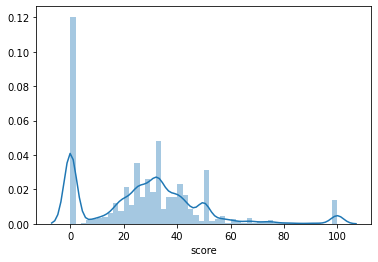

In [18]:
sns.distplot(evaluation.score)

### Evaluation Phase 2: Using Precision and Recall

## Precision

In [21]:
def relevance(x, threshold):
    all_predictions = x.groupby(['prediction']).agg({'score': 'max'}).reset_index()
    found_predictions = len(all_predictions[all_predictions['score'] >= threshold])
    return found_predictions, len(all_predictions)

In [22]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = evaluation.groupby(['pn_num']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.pn_num)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

## Recall

In [23]:
def retrieval(x, threshold):
    all_labels = x.groupby(['ground_truth_annotation']).agg({'score': 'max'}).reset_index()
    found_labels = len(all_labels[all_labels['score'] >= threshold])
    total_predictions = x['prediction'].nunique()
    
    return found_labels, len(all_labels)

In [24]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = evaluation.groupby(['pn_num']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.pn_num)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [25]:
evaluation_df = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['pn_num', 'threshold'])
evaluation_df = evaluation_df[['pn_num', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

evaluation_df['f1_score'] = 2 * (evaluation_df['recall'] * evaluation_df['precision']) / (evaluation_df['recall'] + evaluation_df['precision'])
evaluation_df

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,8,8,12,0.923077,1.000000,0.960000
1,41,10,9,7,5,7,0.777778,0.714286,0.744681
2,46,10,12,6,6,10,0.833333,1.000000,0.909091
3,82,10,13,7,7,12,0.923077,1.000000,0.960000
4,100,10,10,5,5,10,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
9995,95145,100,12,5,2,2,0.166667,0.400000,0.235294
9996,95228,100,7,6,1,1,0.142857,0.166667,0.153846
9997,95243,100,10,7,1,1,0.100000,0.142857,0.117647
9998,95330,100,16,7,3,3,0.187500,0.428571,0.260870


In [26]:
#For a particular patient
evaluation_df[evaluation_df.pn_num==16]

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,8,8,12,0.923077,1.000,0.960000
1000,16,20,13,8,8,12,0.923077,1.000,0.960000
2000,16,30,13,8,8,11,0.846154,1.000,0.916667
3000,16,40,13,8,7,11,0.846154,0.875,0.860335
4000,16,50,13,8,7,9,0.692308,0.875,0.773006
5000,16,60,13,8,2,3,0.230769,0.250,0.240000
6000,16,70,13,8,2,3,0.230769,0.250,0.240000
7000,16,80,13,8,2,3,0.230769,0.250,0.240000
8000,16,90,13,8,2,3,0.230769,0.250,0.240000
9000,16,100,13,8,2,2,0.153846,0.250,0.190476


In [27]:
bio_clinical_bert_evaluation = evaluation_df.merge(test,on="pn_num",how="left")

In [ ]:
bio_clinical_bert_evaluation.to_csv("bio_clinical_bert_evaluation.csv", index=False)

In [ ]:
evaluation_df.to_csv("all_distill_roberta_evaluation_scores.csv",index=False)

### -----x------x---------x---------x-------x